# Big project activity

## Optimal charging station location

### 1.Introduction

Consider a long linear cycle path as Vento, or the Danube cycle path. The cycle path usually runs along the banks of a river with scarce tourist interest. However, from the main course of the cycle path, it is possible to reach places of tourist interest in making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non-negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.



### 2.Decision problem
We can represent the cycle path as a graph where the set of nodes $H = \{1,\ldots, n\}$ corresponds to the tourist sites that may host a charging station.
In addition, we are given the distances between touristic sites ($d_{ij},$ with $ i,j =1,\ldots,n$). Let $c_i$ be the cost of installing a charging station in site $i, i=1\ldots, n$.


The problem is, given a budget $b$, determine the subset of sites $S\subseteq H$ where to install the charging stations so that the total cost is not higher than $b$ and the maximum distance between consecutive charging stations is minimized.
Consider that the cyclist has to visit all the touristic destinations in a consecutive way.



### 3.Problem characteristics
There are 2 csv files that contain the information of the cycle way, they are essential to build the equivalent graph:


*    in the "nodes.csv" file, there are all the destinations that the cyclist can reach, with their spatial coordinates and the value of installation costs related to that destination. Consider that the "tourist-dest-id" is not the graph node number, but it is a unique id to identify the destination.
*   in the "OD.csv" you can find all the arcs between two different nodes, keep attention that the condition of visiting consecutive touristic destination must be respected.

The set of nodes $N$ is defined by $\{0,1,\ldots,n, n+1\}$.  The Arcs $A$ correspond to the portion of cycle path between two consecutive charging stations. We assume that potentially e-riders will visit all sites along the way, making the suitable deviations and going back to the main path at the initial point of the detour.
The cost associated with each arc $(i,j)$ is given by $c_j$, thus the cost of installing a charging station in $j$. These costs are defined for all arcs in $A$, while they are set to 0 for all the arcs that arrive in the last node.
The path starts in node $s = 0$ and ends in node $t = n+1$, these two nodes are connected to the nearest touristic site with an arc of null length.

### 4.Example of a linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)

### 5.Requirements
The requirements of the problem are:


*   the maximum running time of the algorithm must be 5 minutes, so set the proper timer
*   create the equivalent graph and display it on a xy-plot
*   find the solution for the basic scenario, with a mip model, displaying the solution with a xy-plot, the budget constraint is $b = 10000\ € $.
*   Find the optimal solution for 5 different values of budget in the range $[10000, 100000]$. Select the values of the budget so as to have different charger locations.

  You have to motivate your choice and the solution you get. They can also be not common solution if they are well motivated. To support your decision and explanations, you can print plots or tables. You can also compare different scenarios.


   
If you have some doubts related to the parametric analysis, prof. Cubillos uploaded a notebook with the solution on WeBeeP and you can have a look there.

### Insert student name and student ID

student1:

ID1:

student2:

ID2:

student3

ID3:



In [29]:
#install libraries

!pip install mip
!pip install --upgrade cffi == 1.15.0


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Invalid requirement: '=='

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
#import libraries

import importlib
import cffi

importlib.reload(cffi)
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time


In [31]:
#import the csv file

#TO DO
# nodes.csv data corresponds to the candidate installation sites (Nodes)
# including: id, municipality, square, x, y, cost
nodes_data = pd.read_csv('nodes.csv')
print(
    f"Number of candidate touristic sites for installing charging stations sites: {len(nodes_data)}\n"
    f"plus 1 for source and 1 for sink (Numer of Nodes): {len(nodes_data) + 2}")
# including: origin_id, destination_id, distance
# OD.csv data corresponds to d(i,j) which is the distance between candidate installation sites (Arcs)
od_data = pd.read_csv('OD.csv')
print(f"Number of arcs: {len(od_data)}")


Number of candidate touristic sites for installing charging stations sites: 44
plus 1 for source and 1 for sink (Numer of Nodes): 46
Number of arcs: 1936


In [32]:
#set the timer
# Starting time
start_time = time.time()
#TO DO

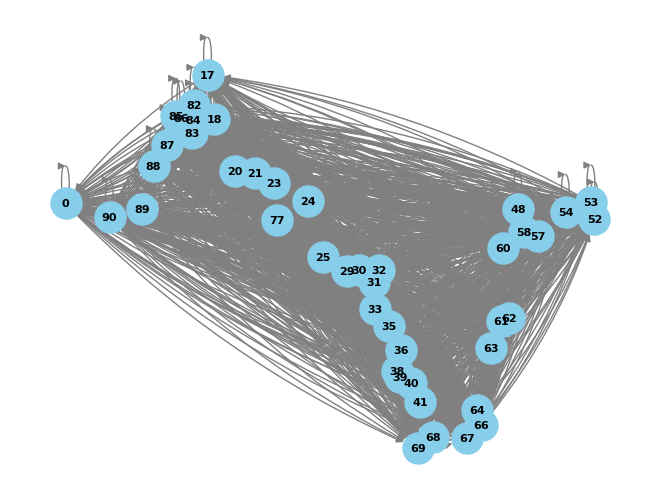

In [67]:
# build the equivalent graph
# Create a directed graph
G = nx.DiGraph()
#define the set of nodes
for i, row in nodes_data.iterrows():
    G.add_node(row["tourist_dest_id"], pos=(row["x (longitude)"], row["y (latitude)"]),
               label=row["Comune"] + " - " + str(row["Piazza"]))
# # TO DO
# #define the set of edges
for i, row in od_data.iterrows():
    G.add_edge(row["origin_id"], row["destination_id"], distance=row["distance [m]"])

# # TO DO
# #plot the graph
pos = nx.get_node_attributes(G, "pos")
# labels = nx.get_node_attributes(G, "label")
# nx.draw(G, pos, with_labels=True, labels=labels, node_size=500, font_size=8, font_color="black", font_weight="bold",
#         node_color="skyblue", edge_color="gray", arrowsize=10, connectionstyle='arc3,rad=0.1')
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=10, connectionstyle='arc3,rad=0.1')
plt.show()
#TO DO


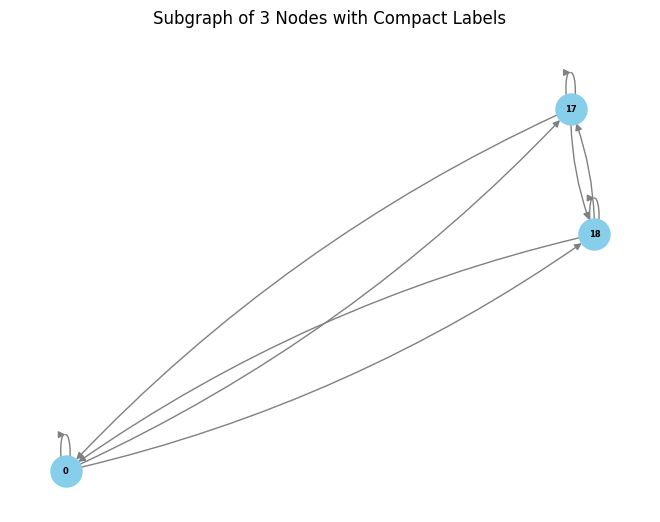

In [70]:
# Get a subgraph of 10 nodes
subgraph_nodes = list(G.nodes)[:3]
subgraph = G.subgraph(subgraph_nodes)

# Plot the subgraph with compact labels
pos = nx.get_node_attributes(subgraph, "pos")
labels = nx.get_node_attributes(subgraph, "label")
compact_labels = {node: f"{node}" for node in subgraph.nodes}  # Modify this for your label format
nx.draw(subgraph, pos, with_labels=True, labels=compact_labels, node_size=500, font_size=6, font_color="black",
        font_weight="bold", node_color="skyblue", edge_color="gray", arrowsize=10, connectionstyle='arc3,rad=0.1')
plt.title('Subgraph of 3 Nodes with Compact Labels')
plt.show()

In [34]:
import mip

# Create model
m = mip.Model()

# define the variables

# TO DO


#  define the constraints


# TO DO


# optimize objective function

# TO DO


m.optimize()

Model has no variables. Nothing to optimize.


<OptimizationStatus.OTHER: 10000>

In [35]:
print(m.objective_value)

None


In [36]:
#plot the graph

#TO DO

In [37]:
# parametric analysis


#TO DO



